In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")

print("Path to dataset files:", path)

100%|██████████| 67.4k/67.4k [00:00<00:00, 434kB/s]

Extracting files...
Path to dataset files: /Users/lelefarias/.cache/kagglehub/datasets/fedesoriano/stroke-prediction-dataset/versions/1


## Parte 1 -  Analise Exploratória

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("healthcare-dataset-stroke-data.csv", encoding='latin1')

### Justificativa DataSet

O DataSet é realacionado ao tema saúde, focado na análise de Acidentes Vascular Cerebral, em inglês 'Stroke'. Com um trabalho bem sucedido é póssivel alertar certos grupos de risco, a fim de redobrar os cuidados e até realizar tratamento preventivo.

In [8]:
df.head()

,id,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status,stroke
0,9046,67.0,0,1,Yes,Private,228.69,formerly smoked,1
1,51676,61.0,0,0,Yes,Self-employed,202.21,never smoked,1
2,31112,80.0,0,1,Yes,Private,105.92,never smoked,1
3,60182,49.0,0,0,Yes,Private,171.23,smokes,1
4,1665,79.0,1,0,Yes,Self-employed,174.12,never smoked,1


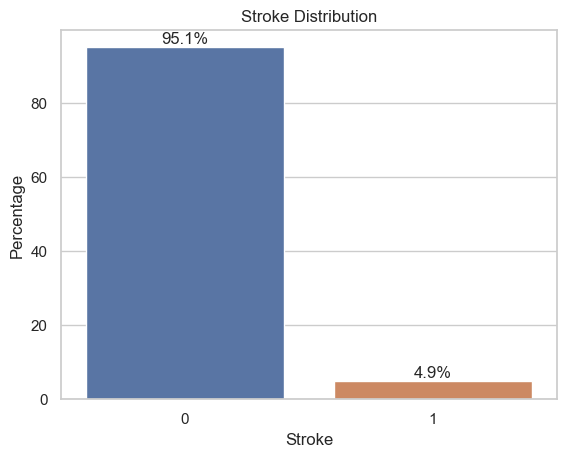

In [22]:
stroke_counts = df['stroke'].value_counts(normalize=True) * 100

# Definindo estilo
sns.set_theme(style="whitegrid")

sns.barplot(
    x=stroke_counts.index,
    y=stroke_counts.values,
    hue=stroke_counts.index,  # Atribuindo 'x' ao 'hue'
    palette='deep',
    legend=False  # Desativando a legenda
)

# Adicionar rótulos e título
plt.xlabel('Stroke')
plt.ylabel('Percentage')
plt.title('Stroke Distribution')

for index, value in enumerate(stroke_counts.values):
    plt.text(index, value + 1, f'{value:.1f}%', ha='center')

plt.show()

#### Investigar valores ausentes

In [23]:
# Verificar a presença de valores ausentes por coluna
valores_ausentes = df.isnull().sum()

# Exibir colunas com valores ausentes
print(valores_ausentes[valores_ausentes > 0])

bmi    201
dtype: int64


In [25]:
df.count()

id                   5110
gender               5110
age                  5110
hypertension         5110
heart_disease        5110
ever_married         5110
work_type            5110
Residence_type       5110
avg_glucose_level    5110
bmi                  4909
smoking_status       5110
stroke               5110
dtype: int64

In [27]:
df[df['stroke'] & df['bmi'].isnull()].stroke.count()

np.int64(40)

In [28]:
df['stroke'].value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

Aos desconsiderar os dados em bmi estaremos perderdendo quase 1/5 dos dados de stroke. Analisar o p valor de BMI, vulgo sua importancia para a classificação de stroke ou não.

#### 🔬 2. Estratégias de Análise:

Stroke é uma variável binária (0 ou 1):

Para variáveis categóricas:
        
    Teste Qui-quadrado (chi² test)
Para variáveis numéricas contínuas: Teste t de Student (t-test) ou Teste de Mann-Whitney se não normal.

In [32]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

# Variáveis categóricas
cat_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
            'work_type', 'Residence_type', 'smoking_status']

# Converter variáveis categóricas para numéricas
df_encoded = df.copy()
label_encoder = LabelEncoder()

for col in cat_cols:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col].astype(str))

# Teste Qui-quadrado
chi_scores, p_values = chi2(df_encoded[cat_cols], df_encoded['stroke'])

# Resultado em DataFrame
result_cat = pd.DataFrame({'Feature': cat_cols, 'Chi2 Score': chi_scores, 'p-value': p_values})
print(result_cat.sort_values('p-value'))


          Feature  Chi2 Score       p-value
2   heart_disease   87.987436  6.587154e-21
1    hypertension   75.449498  3.748736e-18
3    ever_married   20.622787  5.592648e-06
6  smoking_status    3.369423  6.641702e-02
4       work_type    2.925901  8.716857e-02
5  Residence_type    0.600717  4.383046e-01
0          gender    0.239001  6.249287e-01




#### 📌 **Interpretação dos Resultados:**

- **`heart_disease`** e **`hypertension`** têm valores extremamente altos, indicando forte associação com `stroke`. Essas variáveis são estatisticamente muito significativas (p-valores extremamente baixos).

- **`ever_married`** também possui um valor alto, indicando associação significativa com `stroke`, embora não tão forte quanto as anteriores.

- **`smoking_status`** e **`work_type`** têm valores indicando uma associação moderada ou fraca com `stroke` (com p-valores próximos do intervalo 0.05–0.1).

- **`Residence_type`** e **`gender`** apresentam valores normalizados baixos, indicando que essas variáveis não têm associação estatisticamente significativa com o evento `stroke` (altos p-valores, bem acima do limite padrão de 0.05).

In [33]:
import pandas as pd
from sklearn.feature_selection import f_classif

# Variáveis numéricas
num_cols = ['age', 'avg_glucose_level', 'bmi']

# Removendo linhas com valores ausentes
df_clean = df.dropna(subset=num_cols + ['stroke'])

# Aplicando ANOVA (f_classif)
f_values, p_values = f_classif(df_clean[num_cols], df_clean['stroke'])

# Exibindo resultados em DataFrame
results_df = pd.DataFrame({
    'Feature': num_cols,
    'F-Value': f_values,
    'P-Value': p_values
}).sort_values('P-Value')

print(results_df)

             Feature     F-Value       P-Value
0                age  279.980918  3.655693e-61
1  avg_glucose_level   96.585072  1.379969e-22
2                bmi    8.826500  2.983269e-03


#### 📌 **Interpretação dos Resultados:**

- **`age` (p ≈ 3.66e-61)**:
  - Apresenta um valor extremamente baixo, indicando uma associação muito forte e estatisticamente significativa com o evento `stroke`. Em outras palavras, a idade é um fator altamente relevante na ocorrência do acidente vascular cerebral.

- **`avg_glucose_level` (p ≈ 1.38e-22)**:
  - Também apresenta uma associação muito forte, com um p-valor extremamente baixo, sugerindo que níveis mais altos de glicose têm forte relevância estatística na ocorrência do `stroke`.

- **`bmi` (p ≈ 2.98e-03)**:
  - Possui um p-valor baixo (menor que 0.05), indicando uma associação significativa com o `stroke`, embora muito menos intensa do que as variáveis anteriores. A relevância dessa variável é moderada, mas estatisticamente válida.

#### 🚩 **Conclusões e Recomendações:**
- **`age`** e **`avg_glucose_level`** devem ser consideradas variáveis-chave em qualquer modelo preditivo ou análise exploratória relacionada ao risco de stroke.
- **`bmi`**, embora significativa, tem relevância moderada e pode ser incluída, mas não priorizada em comparação com as outras duas variáveis.

#### Como a associação de BMI é modera vou testar dois caminho:

        eliminar a coluna BMI e na outra eliminar somente as rows nulas. Como residencia e genereno não foram fatores determinantes, serão desconsiderados.

## Parte 2.1 - Primeira abordagem, sem a  coluna BMI

In [3]:
df.drop(columns=['bmi','Residence_type', 'gender'], inplace=True)

In [37]:
df.columns

Index(['id', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'avg_glucose_level', 'smoking_status', 'stroke'],
      dtype='object')

### Regreção logistica

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

df_clean = df.copy()

# Features mais relevantes identificadas anteriormente
features = ['age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'avg_glucose_level', 'smoking_status']

# Codifique variáveis categóricas
label_enc = LabelEncoder()
df_clean['ever_married'] = label_enc.fit_transform(df_clean['ever_married'])
df_clean['hypertension'] = label_enc.fit_transform(df_clean['hypertension'])
df_clean['work_type'] = label_enc.fit_transform(df_clean['work_type'])
df_clean['smoking_status'] = label_enc.fit_transform(df_clean['smoking_status'])
df_clean['heart_disease'] = label_enc.fit_transform(df_clean['heart_disease'])

# Defina X e y
X = df_clean[features]
y = df_clean['stroke']

# Padronização das variáveis numéricas
scaler = StandardScaler()
X.loc[:, ['age', 'avg_glucose_level']] = scaler.fit_transform(X[['age', 'avg_glucose_level']])

# Divisão treino/teste (70%-30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinar o modelo de regressão logística
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

# Fazer predições
y_pred = logreg.predict(X_test)

# Avaliar o modelo
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.00      0.00      0.00        89

    accuracy                           0.94      1533
   macro avg       0.47      0.50      0.49      1533
weighted avg       0.89      0.94      0.91      1533

Confusion Matrix:
[[1444    0]
 [  89    0]]


/Users/lelefarias/Dev/UFCG CODE/cdp/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lelefarias/Dev/UFCG CODE/cdp/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lelefarias/Dev/UFCG CODE/cdp/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

#### 🔍 **Analisando detalhadamente:**

#### ✅ **Matriz de confusão:**
|                   | Predito = 0 | Predito = 1 |
|-------------------|-------------|-------------|
| **Real = 0**      | 1444 (TP ✅)| 0 (FN)      |
| **Real = 1**      | 89 (FP ❌)  | 0 (TN ❌)    |

- **TP (True Positive)**: Casos negativos corretamente classificados como **não-stroke**: **1444**
- **FP (False Positive)**: Casos positivos (**stroke**) classificados erroneamente como **não-stroke**: **89**
- O modelo não identificou **nenhum caso positivo (stroke)** corretamente.

---

#### 📉 **Métricas importantes:**

- **Precisão (`precision`)** para classe `stroke = 1`: **0.00**
  - O modelo não previu nenhum caso positivo corretamente.

- **Recall** para classe `stroke = 1`: **0.00**
  - Não detectou nenhum dos casos reais de stroke.

- **f1-score** para classe `stroke = 1`: **0.00**
  - Consequência das métricas anteriores (nenhuma predição correta).

- **Acurácia** geral (**0.94**):  
  - Alta, mas enganosa devido ao forte desbalanceamento. O modelo simplesmente prevê que ninguém teve um stroke, acertando a maioria dos casos (não-stroke).



Agora Balanceada

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

df_clean = df.copy()

# Features mais relevantes identificadas anteriormente
features = ['age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'avg_glucose_level', 'smoking_status']

# Codifique variáveis categóricas
label_enc = LabelEncoder()
df_clean['ever_married'] = label_enc.fit_transform(df_clean['ever_married'])
df_clean['hypertension'] = label_enc.fit_transform(df_clean['hypertension'])
df_clean['work_type'] = label_enc.fit_transform(df_clean['work_type'])
df_clean['smoking_status'] = label_enc.fit_transform(df_clean['smoking_status'])
df_clean['heart_disease'] = label_enc.fit_transform(df_clean['heart_disease'])

# Defina X e y
X = df_clean[features]
y = df_clean['stroke']

# Padronização das variáveis numéricas
scaler = StandardScaler()
X.loc[:, ['age', 'avg_glucose_level']] = scaler.fit_transform(X[['age', 'avg_glucose_level']])

# Divisão treino/teste (70%-30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinar o modelo de regressão logística
logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

# Fazer predições
y_pred = logreg.predict(X_test)

# Avaliar o modelo
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.74      0.85      1444
           1       0.15      0.74      0.25        89

    accuracy                           0.74      1533
   macro avg       0.57      0.74      0.55      1533
weighted avg       0.93      0.74      0.81      1533

Confusion Matrix:
[[1074  370]
 [  23   66]]


#### ✅ **Matriz de confusão:**
|                   | Predito = 0 | Predito = 1 |
|-------------------|-------------|-------------|
| **Real = 0**      | 1074 (TP ✅)| 370 (FP ❌)  |
| **Real = 1**      | 23 (FN ❌)  | 66 (TN ✅)   |


O balanceamento não resolve o problema

### Árvore de decisão

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

df_clean = df.copy()

# Selecionando features importantes
features = ['age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'avg_glucose_level', 'smoking_status']

# Codificando variáveis categóricas
label_enc = LabelEncoder()
df_clean['ever_married'] = label_enc.fit_transform(df_clean['ever_married'])
df_clean['hypertension'] = label_enc.fit_transform(df_clean['hypertension'])
df_clean['work_type'] = label_enc.fit_transform(df_clean['work_type'])
df_clean['smoking_status'] = label_enc.fit_transform(df_clean['smoking_status'])
df_clean['heart_disease'] = label_enc.fit_transform(df_clean['heart_disease'])

# Definindo X e y
X = df_clean[features]
y = df_clean['stroke']

# Padronização das variáveis numéricas
scaler = StandardScaler()
X.loc[:, ['age', 'avg_glucose_level']] = scaler.fit_transform(X[['age', 'avg_glucose_level']])

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Treinando a árvore de decisão (com balanceamento de classes)
dtree = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dtree.fit(X_train, y_train)

# Realizando as predições
y_pred = dtree.predict(X_test)

# Avaliando o modelo
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      1458
           1       0.17      0.20      0.18        75

    accuracy                           0.91      1533
   macro avg       0.56      0.57      0.57      1533
weighted avg       0.92      0.91      0.92      1533

Confusion Matrix:
 [[1385   73]
 [  60   15]]


#### ✅ **Matriz de confusão:**
|                   | Predito = 0 | Predito = 1 |
|-------------------|-------------|-------------|
| **Real = 0**      | 1385 (TP ✅)| 73 (FP ❌)     |
| **Real = 1**      | 60 (FP ❌)  | 15 (TN ✅)    |

### KNN

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

df_clean = df.copy()

# Selecionando features importantes
features = ['age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'avg_glucose_level', 'smoking_status']

# Codificando variáveis categóricas
label_enc = LabelEncoder()
df_clean['ever_married'] = label_enc.fit_transform(df_clean['ever_married'])
df_clean['hypertension'] = label_enc.fit_transform(df_clean['hypertension'])
df_clean['work_type'] = label_enc.fit_transform(df_clean['work_type'])
df_clean['smoking_status'] = label_enc.fit_transform(df_clean['smoking_status'])
df_clean['heart_disease'] = label_enc.fit_transform(df_clean['heart_disease'])

# Definindo X e y
X = df_clean[features]
y = df_clean['stroke']

# Padronização das variáveis numéricas
scaler = StandardScaler()
X.loc[:, ['age', 'avg_glucose_level']] = scaler.fit_transform(X[['age', 'avg_glucose_level']])

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Treinando o modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)  # você pode ajustar o valor de k (n_neighbors)
knn.fit(X_train, y_train)

# Realizando as predições
y_pred_knn = knn.predict(X_test)

# Avaliando o modelo
print("Classification Report (KNN):\n", classification_report(y_test, y_pred_knn))
print("Confusion Matrix (KNN):\n", confusion_matrix(y_test, y_pred_knn))


Classification Report (KNN):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1458
           1       0.29      0.07      0.11        75

    accuracy                           0.95      1533
   macro avg       0.62      0.53      0.54      1533
weighted avg       0.92      0.95      0.93      1533

Confusion Matrix (KNN):
 [[1446   12]
 [  70    5]]


#### ✅ **Matriz de confusão:**
|                   | Predito = 0 | Predito = 1 |
|-------------------|-------------|-------------|
| **Real = 0**      | 1446 (TP ✅)| 12 (FP ❌)     |
| **Real = 1**      | 70 (FP ❌)  | 5 (TN ✅)    |

## Parte 2.2 - Segunda abordagem, com coluna BMI 

### Regreção logistica

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_csv("healthcare-dataset-stroke-data.csv", encoding='latin1')
df_clean = df.copy().dropna()

# Features mais relevantes identificadas anteriormente
features = ['age', 'bmi', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'avg_glucose_level', 'smoking_status']

# Codifique variáveis categóricas
label_enc = LabelEncoder()
df_clean['ever_married'] = label_enc.fit_transform(df_clean['ever_married'])
df_clean['hypertension'] = label_enc.fit_transform(df_clean['hypertension'])
df_clean['work_type'] = label_enc.fit_transform(df_clean['work_type'])
df_clean['smoking_status'] = label_enc.fit_transform(df_clean['smoking_status'])
df_clean['heart_disease'] = label_enc.fit_transform(df_clean['heart_disease'])

# Defina X e y
X = df_clean[features]
y = df_clean['stroke']

# Padronização das variáveis numéricas
scaler = StandardScaler()
X.loc[:, ['age', 'avg_glucose_level']] = scaler.fit_transform(X[['age', 'avg_glucose_level']])

# Divisão treino/teste (70%-30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinar o modelo de regressão logística
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

# Fazer predições
y_pred = logreg.predict(X_test)

# Avaliar o modelo
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1401
           1       0.00      0.00      0.00        72

    accuracy                           0.95      1473
   macro avg       0.48      0.50      0.49      1473
weighted avg       0.90      0.95      0.93      1473

Confusion Matrix:
[[1401    0]
 [  72    0]]


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### 🔍 **Analisando detalhadamente:**

#### ✅ **Matriz de confusão:**
|                   | Predito = 0 | Predito = 1 |
|-------------------|-------------|-------------|
| **Real = 0**      | 1401 (TP ✅)| 0 (FN)      |
| **Real = 1**      | 72 (FP ❌)  | 0 (TN ❌)    |


- Resultados similires sem a coluna BMI, um modelo não confiavel que prediz 0 para maioria dos casos

Agora Balanceada

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_csv("healthcare-dataset-stroke-data.csv", encoding='latin1')
df_clean = df.copy().dropna()

# Features mais relevantes identificadas anteriormente
features = ['age', 'bmi', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'avg_glucose_level', 'smoking_status']

# Codifique variáveis categóricas
label_enc = LabelEncoder()
df_clean['ever_married'] = label_enc.fit_transform(df_clean['ever_married'])
df_clean['hypertension'] = label_enc.fit_transform(df_clean['hypertension'])
df_clean['work_type'] = label_enc.fit_transform(df_clean['work_type'])
df_clean['smoking_status'] = label_enc.fit_transform(df_clean['smoking_status'])
df_clean['heart_disease'] = label_enc.fit_transform(df_clean['heart_disease'])

# Defina X e y
X = df_clean[features]
y = df_clean['stroke']

# Padronização das variáveis numéricas
scaler = StandardScaler()
X.loc[:, ['age', 'avg_glucose_level']] = scaler.fit_transform(X[['age', 'avg_glucose_level']])

# Divisão treino/teste (70%-30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinar o modelo de regressão logística
logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

# Fazer predições
y_pred = logreg.predict(X_test)

# Avaliar o modelo
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1401
           1       0.14      0.86      0.24        72

    accuracy                           0.74      1473
   macro avg       0.57      0.80      0.54      1473
weighted avg       0.95      0.74      0.81      1473

Confusion Matrix:
[[1024  377]
 [  10   62]]


#### ✅ **Matriz de confusão:**
|                   | Predito = 0 | Predito = 1 |
|-------------------|-------------|-------------|
| **Real = 0**      | 1024 (TP ✅)| 377 (FP❌)     |
| **Real = 1**      | 10 (FN ❌)  | 62 (TN ✅)    |


modelo se tornou mais confiavel, agora não presume que todos são não stroke, porem ainda apresenta metricas muito baixas para valor 1, stroke

### Árvore de decisão

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_csv("healthcare-dataset-stroke-data.csv", encoding='latin1')
df_clean = df.copy().dropna()

# Selecionando features importantes
features = ['age', 'bmi', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'avg_glucose_level', 'smoking_status']

# Codificando variáveis categóricas
label_enc = LabelEncoder()
df_clean['ever_married'] = label_enc.fit_transform(df_clean['ever_married'])
df_clean['hypertension'] = label_enc.fit_transform(df_clean['hypertension'])
df_clean['work_type'] = label_enc.fit_transform(df_clean['work_type'])
df_clean['smoking_status'] = label_enc.fit_transform(df_clean['smoking_status'])
df_clean['heart_disease'] = label_enc.fit_transform(df_clean['heart_disease'])

# Definindo X e y
X = df_clean[features]
y = df_clean['stroke']

# Padronização das variáveis numéricas
scaler = StandardScaler()
X.loc[:, ['age', 'avg_glucose_level']] = scaler.fit_transform(X[['age', 'avg_glucose_level']])

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Treinando a árvore de decisão (com balanceamento de classes)
dtree = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dtree.fit(X_train, y_train)

# Realizando as predições
y_pred = dtree.predict(X_test)

# Avaliando o modelo
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      1410
           1       0.09      0.08      0.08        63

    accuracy                           0.93      1473
   macro avg       0.52      0.52      0.52      1473
weighted avg       0.92      0.93      0.92      1473

Confusion Matrix:
 [[1359   51]
 [  58    5]]


#### ✅ **Matriz de confusão:**
|                   | Predito = 0 | Predito = 1 |
|-------------------|-------------|-------------|
| **Real = 0**      | 1359 (TP ✅)| 51 (FP ❌)     |
| **Real = 1**      | 58 (Fn ❌)  |  5 (TN ✅)    |

mesmo com uma coluna a mais BMI, ter menos dados classificados como STROKE piorou a perfomae do modelo de Arvore de decisão

### KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_csv("healthcare-dataset-stroke-data.csv", encoding='latin1')
df_clean = df.copy().dropna()

# Selecionando features importantes
features = ['age', 'bmi', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'avg_glucose_level', 'smoking_status']

# Codificando variáveis categóricas
label_enc = LabelEncoder()
df_clean['ever_married'] = label_enc.fit_transform(df_clean['ever_married'])
df_clean['hypertension'] = label_enc.fit_transform(df_clean['hypertension'])
df_clean['work_type'] = label_enc.fit_transform(df_clean['work_type'])
df_clean['smoking_status'] = label_enc.fit_transform(df_clean['smoking_status'])
df_clean['heart_disease'] = label_enc.fit_transform(df_clean['heart_disease'])

# Definindo X e y
X = df_clean[features]
y = df_clean['stroke']

# Padronização das variáveis numéricas
scaler = StandardScaler()
X.loc[:, ['age', 'avg_glucose_level']] = scaler.fit_transform(X[['age', 'avg_glucose_level']])

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Treinando o modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)  # você pode ajustar o valor de k (n_neighbors)
knn.fit(X_train, y_train)

# Realizando as predições
y_pred_knn = knn.predict(X_test)

# Avaliando o modelo
print("Classification Report (KNN):\n", classification_report(y_test, y_pred_knn))
print("Confusion Matrix (KNN):\n", confusion_matrix(y_test, y_pred_knn))


Classification Report (KNN):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1410
           1       0.00      0.00      0.00        63

    accuracy                           0.96      1473
   macro avg       0.48      0.50      0.49      1473
weighted avg       0.92      0.96      0.94      1473

Confusion Matrix (KNN):
 [[1408    2]
 [  63    0]]



## ✅🔍 **1. Regressão Logística**

### ✔️ Vantagens:
- **Interpretação clara e direta**:
  - Você pode ver os coeficientes e entender o impacto de cada feature.
- **Rápida e eficiente em datasets pequenos/médios**.
- **Fácil de regularizar** (`L1`, `L2`) e balancear (`class_weight='balanced'`).
- Funciona bem quando a relação entre variáveis é **linear**.
- **Boa base de comparação** para outros modelos.

### ❌ Limitações:
- **Assume linearidade** entre variáveis e a saída — pode não capturar bem padrões complexos.
- **Desempenho limitado em problemas não lineares ou com muitas interações entre features**.
- Sensível à **multicolinearidade** (features altamente correlacionadas).
- Pode **subestimar** relações sutis ou não lineares presentes nos dados.

---

## 🧊📍 **2. KNN (K-Nearest Neighbors)**

### ✔️ Vantagens:
- **Modelo não-paramétrico**: não faz suposições sobre a distribuição dos dados.
- Simples de implementar e entender.
- **Capta relações não lineares** de forma natural.
- Pode ser poderoso se os dados forem bem separados e normalizados.

### ❌ Limitações:
- **Muito sensível ao desbalanceamento** de classes (como no seu caso!).
- **Desempenho ruim com dados esparsos ou com muito ruído**.
- **Muito custo computacional** em datasets grandes (precisa calcular distância para todos os pontos).
- Resultado depende **fortemente da escolha de K e da métrica de distância**.
- Difícil de interpretar **por que** uma previsão foi feita (modelo de “caixa preta”).

---

## 🌳📊 **3. Decision Tree (Árvore de Decisão)**

### ✔️ Vantagens:
- **Interpretação visual e lógica fácil**: é possível "seguir o caminho" da árvore.
- **Captura bem relações não lineares e interações entre variáveis**.
- Funciona bem com dados mistos (numéricos e categóricos).
- Não requer normalização dos dados.
- **Pode lidar melhor com features irrelevantes ou redundantes** (via poda).

### ❌ Limitações:
- **Tende a overfitting**, especialmente com árvores profundas e sem poda.
- Sensível a **pequenas variações nos dados** (pode mudar bastante com dados levemente diferentes).
- Sozinha, **tem dificuldade com dados desbalanceados**, como mostrado no seu caso.
- Pode criar **limites de decisão pouco suaves**, que não generalizam bem.

---

## 🧠 **Resumo Comparativo:

| Modelo             | Interpretação | Tolerância a Desbalanceamento | Não-linearidade | Overfitting | Desempenho observado |
|--------------------|---------------|-------------------------------|-----------------|-------------|----------------------|
| Regressão Logística | ✅ Alta       | ✅ Sim (com `balanced`)       | ❌ Não           | 🔘 Baixo     | **Melhor F1**        |
| KNN                | ❌ Baixa       | ❌ Ruim (sofre muito)         | ✅ Sim           | 🔘 Médio     | Baixo recall classe 1 |
| Decision Tree      | 🔘 Média       | ❌ Limitada (sem ajuste)      | ✅ Sim           | ✅ Alto      | Recall fraco, possível overfitting |


## Parte 3 - Ensemble Learning

- pelos resultados anteriores preferi ter mais dados de STROKE e retirar a coluna BMI para lidar com os nulos

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

df_clean = df.copy()

# Selecionando features importantes
features = ['age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'avg_glucose_level', 'smoking_status']

# Codifique variáveis categóricas
label_enc = LabelEncoder()
df_clean['ever_married'] = label_enc.fit_transform(df_clean['ever_married'])
df_clean['hypertension'] = label_enc.fit_transform(df_clean['hypertension'])
df_clean['work_type'] = label_enc.fit_transform(df_clean['work_type'])
df_clean['smoking_status'] = label_enc.fit_transform(df_clean['smoking_status'])
df_clean['heart_disease'] = label_enc.fit_transform(df_clean['heart_disease'])

# Defina X e y
X = df_clean[features]
y = df_clean['stroke']

# Padronização das variáveis numéricas
scaler = StandardScaler()
X.loc[:, ['age', 'avg_glucose_level']] = scaler.fit_transform(X[['age', 'avg_glucose_level']])

# Divisão treino/teste (70%-30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinar o modelo de regressão logística
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Avaliar o modelo
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1444
           1       0.18      0.02      0.04        89

    accuracy                           0.94      1533
   macro avg       0.56      0.51      0.50      1533
weighted avg       0.90      0.94      0.91      1533

Confusion Matrix:
[[1435    9]
 [  87    2]]


### Adaboost

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Copiando e preparando os dados
df_clean = df.copy()

features = ['age', 'hypertension', 'heart_disease', 'ever_married',
            'work_type', 'avg_glucose_level', 'smoking_status']

# Codificação de variáveis categóricas
label_enc = LabelEncoder()
df_clean['ever_married'] = label_enc.fit_transform(df_clean['ever_married'])
df_clean['hypertension'] = label_enc.fit_transform(df_clean['hypertension'])
df_clean['work_type'] = label_enc.fit_transform(df_clean['work_type'])
df_clean['smoking_status'] = label_enc.fit_transform(df_clean['smoking_status'])
df_clean['heart_disease'] = label_enc.fit_transform(df_clean['heart_disease'])

# Separando X e y
X = df_clean[features]
y = df_clean['stroke']

# Padronizando variáveis numéricas
scaler = StandardScaler()
X[['age', 'avg_glucose_level']] = scaler.fit_transform(X[['age', 'avg_glucose_level']])

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Criando um modelo base (stump) e aplicando AdaBoost
base_model = DecisionTreeClassifier(max_depth=1, class_weight='balanced')  # "stump" com balanceamento
ada_model = AdaBoostClassifier(estimator=base_model, n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)

# Predição e avaliação
y_pred_ada = ada_model.predict(X_test)

print("Classification Report (AdaBoost):\n", classification_report(y_test, y_pred_ada))
print("Confusion Matrix (AdaBoost):\n", confusion_matrix(y_test, y_pred_ada))

Classification Report (AdaBoost):
               precision    recall  f1-score   support

           0       0.99      0.57      0.72      1458
           1       0.09      0.87      0.17        75

    accuracy                           0.59      1533
   macro avg       0.54      0.72      0.45      1533
weighted avg       0.94      0.59      0.70      1533

Confusion Matrix (AdaBoost):
 [[834 624]
 [ 10  65]]


/var/folders/hr/0brpjq8x195496zt0bkvsnrw0000gn/T/ipykernel_96085/1258302296.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['age', 'avg_glucose_level']] = scaler.fit_transform(X[['age', 'avg_glucose_level']])


comparação entre modelos feita em tabela a seguir.

## Parte 4 - Análise Comparativa e Discussão


### 📊 **Tabela Comparativa dos Modelos**

| Modelo                 | Acurácia | Precision (Classe 1)   | Recall (Classe 1)   | F1-Score (Classe 1) |
|------------------      |----------|------------------------|---------------------|----------------------|
| **Regreção log (balanced)**| **0.74**     | 0.15                   | **0.74**                | **0.25**                 |
| Decision Tree          | 0.91     | 0.17                   | 0.20                | 0.18                 |
| KNN                    | 0.95     | 0.29                   | 0.07                | 0.11                 |
| **AdaBoost**           | 0.59     | 0.09                   | **0.87**            | **0.17**             |
| RandomForest           | 0.94     | 0.18                   |  0.02               |  0.04            |

---

### ✅ **1. Melhor Desempenho — Qual abordagem foi melhor?**

Depende do que você considera "melhor", mas geralmente:

- Se o foco é **identificar corretamente a maioria dos casos positivos** (classe 1), o modelo mais importante será o que tiver **maior recall na classe 1**.
- Se o foco é equilibrar entre **não errar ao prever** e **não deixar passar casos**, olhamos para o **F1-score**.

#### 🔍 Pela análise:
- **Maior recall (Classe 1)**: **AdaBoost** com **0.87**
- **Maior F1-score (Classe 1)**: **Regressão Logística Balanceada** com **0.25**
- **Maior precisão (Classe 1)**: **KNN**, com **0.29** (mas com recall muito baixo)
- **Maior acurácia geral**: **KNN** com **0.95** (enganosa, pois ignora a classe minoritária)

✅ **Conclusão:**
> **A Regressão Logística com `class_weight=balanced` foi o modelo com melhor equilíbrio entre recall e precisão para a classe 1**, mesmo com acurácia menor.  
> O **AdaBoost** teve o maior recall, o que pode ser desejável se o custo de *perder um positivo* for alto, mas sua precisão foi muito baixa.

---

### ⚠️ **2. Há sinais de overfitting ou underfitting?**

- **RandomForest com recall 0.02 e alta acurácia (0.94)**:
  - Isso indica **overfitting** à classe majoritária. O modelo aprendeu muito bem os padrões da classe 0, mas ignora a classe 1.

- **AdaBoost com baixa acurácia geral (0.59) e alto recall (0.87)**:
  - Pode estar **overcorrigindo para detectar positivos**, prevendo demais como 1 → muitos falsos positivos → **underfitting na classe 0**.

- **KNN com alta precisão (0.29) e recall baixíssimo (0.07)**:
  - **Underfitting** na classe 1 — não está conseguindo identificar quase nenhum caso positivo.

✅ **Sinal claro de desbalanceamento afetando todos os modelos**. A regressão logística balanceada encontrou um **compromisso razoável**.

---

### **3. O modelo mais acurado também é o mais interpretável?**

Não para todos os casos, mas neste a afirmação é verdadeira!

| Modelo                | Interpretabilidade |
|-----------------------|--------------------|
| **Regressão Logística** | **Alta** ✅ (coeficientes claros, simples) |
| Decision Tree         | Média (visível como árvore, mas cresce rápido) |
| KNN                   | Baixa (difícil de interpretar como decide) |
| AdaBoost              | Baixa (modelo em ensemble, múltiplas iterações) |
| RandomForest          | Baixa (ensemble de árvores, difícil rastrear decisões) |

✅ **Regressão Logística** é a mais interpretável e transparente. Ótimo para explicar decisões, identificar influência das variáveis, etc.

---

###  **4. Como o modelo pode ser usado (ou mal utilizado) em um cenário real?**

#### ✔️ **Uso correto:**
- Em contextos onde a **classe 1 representa um evento crítico** (ex: fraude, doença rara, falha de sistema), o modelo deve ter **alto recall** — identificar ao máximo os casos reais.
- A regressão logística balanceada ou o AdaBoost são úteis aqui.

#### ❌ **Uso indevido:**
- Se o modelo for usado sem considerar o desbalanceamento, ele pode **ignorar completamente a classe 1** e **dar uma falsa sensação de sucesso** (ex: "tenho 95% de acurácia!").
- Modelos como RandomForest ou KNN, sem ajuste, **não são confiáveis nesse cenário**.
- Usar AdaBoost com alto recall, mas precisão 0.09, pode gerar **muitos falsos alarmes**, o que pode **sobrecarregar equipes, gerar desconfiança no sistema ou até perdas financeiras**.